In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

from utils import Dataset
from models import RegressionModel, LogisticModel

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Линейная регрессия

Задана модель линейной регрессии:
$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n}, $$
$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_{\mathbf{x}}, \mathbf{\Sigma}_{\mathbf{x}}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}), $$
$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  \sigma^2). $$

Обозначим априорное распределение параметров
$$ p(\mathbf{w}) = \mathcal{N} \left( \mathbf{w} | \mathbf{m}_0, \mathbf{\Sigma}_0 \right), $$
где чаще всего будут встречаться $\mathbf{m}_0 = \mathbf{0}$ и $\mathbf{\Sigma}_0 = \alpha^{-1} \mathbf{I}$.
Апостериорное распределение параметров:
$$ p(\mathbf{w} | \mathbf{X}, \mathbf{y}) = \mathcal{N}\left( \mathbf{w} | \mathbf{m}, \mathbf{\Sigma} \right), $$
где математическое ожидание и ковариационная матрица есть
$$ \mathbf{\Sigma} = \left( \mathbf{\Sigma}_0^{-1} + \dfrac{1}{\sigma^2} \mathbf{X}^\top \mathbf{X} \right)^{-1}, $$
$$ \mathbf{m} = \mathbf{\Sigma} \left( \dfrac{1}{\sigma^2} \mathbf{X}^\top \mathbf{y} + \mathbf{\Sigma}_0^{-1} \mathbf{m}_0 \right). $$

Пусть заданы две подвыборки размера $k$ и $k+1$. Рассмотрим апостериорное распредление параметров, полученное по каждой из подвыборок:
$$ p_k(\mathbf{w}) = p(\mathbf{w} | \mathbf{X}_k, \mathbf{y}_k) = \mathcal{N}\left( \mathbf{w} | \mathbf{m}_k, \mathbf{\Sigma}_k \right). $$

Если размер выбор достаточен, то эти апостериорные распредления должны быть похожи. Их схожесть можно толковать по-разному.

## Дивергенция Кульбака-Лейблера

Для нормальных распределений известна формула дивергенции Кульбака-Лейблера. Применяя ее, находим
$$ D_{KL}\left( p_k \| p_{k+1} \right) = \dfrac{1}{2} \left( \mathrm{tr}\left( \mathbf{\Sigma}_{k+1}^{-1} \mathbf{\Sigma}_k \right) + (\mathbf{m}_{k+1} - \mathbf{m}_k)^\top \mathbf{\Sigma}_{k+1}^{-1} (\mathbf{m}_{k+1} - \mathbf{m}_k) - n + \log{\left( \dfrac{\det \mathbf{\Sigma}_{k+1}}{\det \mathbf{\Sigma}_{k}} \right)} \right). $$

In [2]:
def KL(mk, Sk, mkp1, Skp1):
    return 1/2 * (np.trace(np.linalg.inv(Skp1) @ Sk) + (mkp1 - mk) @ np.linalg.inv(Skp1) @ (mkp1 - mk) - mk.size + np.log(np.linalg.det(Skp1) / np.linalg.det(Sk)))

In [12]:
m = 100
n = 5

mu_x = np.zeros(n)
Sigma_x = np.identity(n)

sigma2 = 1

alpha = 1
m0 = np.zeros(n)
Sigma0 = alpha**(-1) * np.identity(n)

In [13]:
X = sps.multivariate_normal(mean=mu_x, cov=Sigma_x).rvs(size=m)
w = sps.multivariate_normal(mean=m0, cov=Sigma0).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [14]:
dataset = Dataset(X, y)

In [17]:
def posterior_parameters(m0, Sigma0, X, y, sigma2=1):
    Sigma = np.linalg.inv(np.linalg.inv(Sigma0) + 1/sigma2 * X.T @ X)
    m = Sigma @ (1/sigma2 * X.T @ y + np.linalg.inv(Sigma0) @ m0)
    return m, Sigma

Последовательно удаляем один случайный объект из выборки. Делаем так, пока не дойдем до количества объектов = количеству признаков. Повторяем такой процесс N раз и усредняем результаты.

In [26]:
N = 100
matrix = []

for _ in range(N): # делаем усреднение по 100 проходам

    divergences = []

    k = m-1
    Xkp1, ykp1 = X, y
    mkp1, Skp1 = posterior_parameters(m0, Sigma0, Xkp1, ykp1)
    
    while k > n:
        index = np.random.randint(k)
        Xk, yk = np.delete(Xkp1, index, axis=0), np.delete(ykp1, index, axis=0)
        mk, Sk = posterior_parameters(m0, Sigma0, Xk, yk)
        divergences.append(KL(mk, Sk, mkp1, Skp1))
        Xkp1, ykp1 = Xk, yk
        mkp1, Skp1 = mk, Sk
        k -= 1
        
    matrix.append(divergences)
    
matrix = np.array(matrix)

In [29]:
means = matrix.mean(axis=0)[::-1]
stds = matrix.std(axis=0)[::-1]

In [42]:
sample_sizes = np.arange(n+1, m)

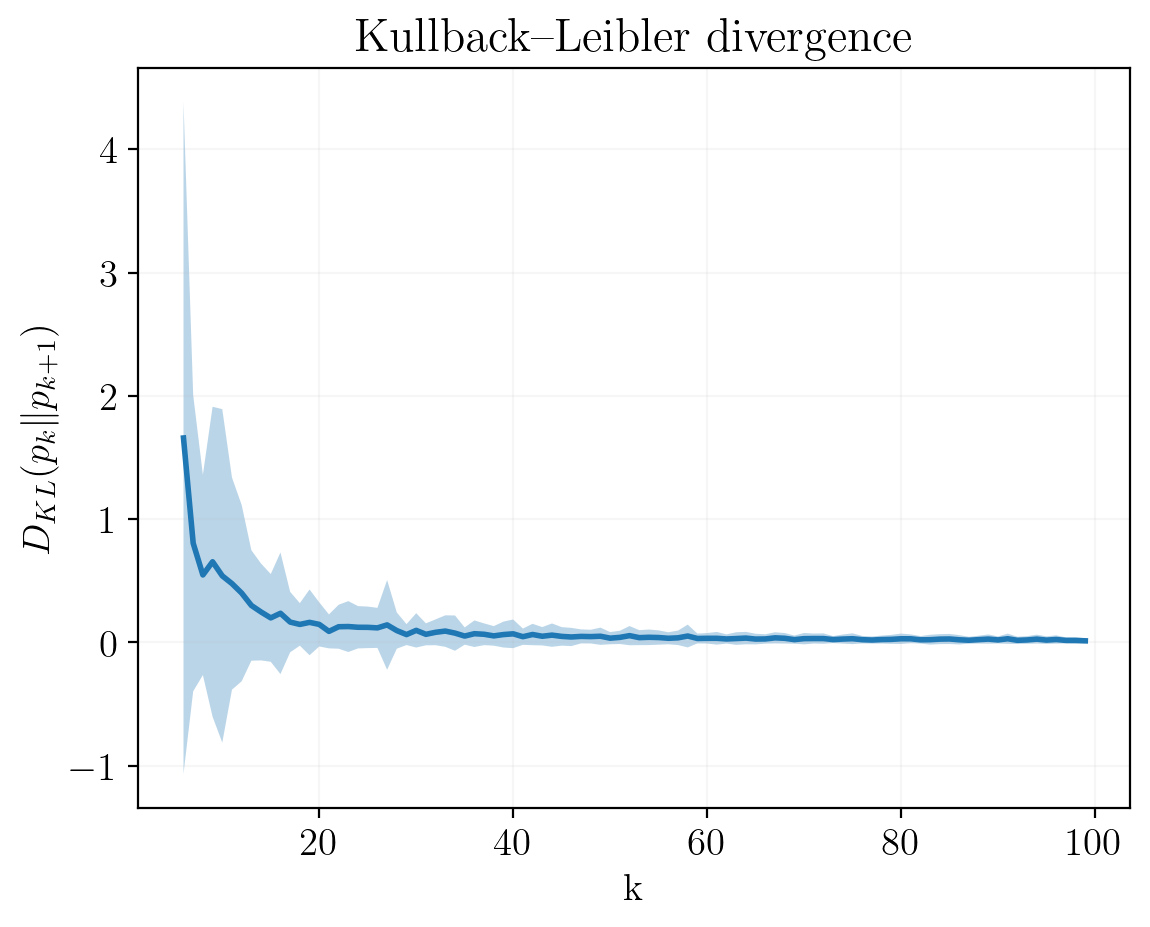

In [46]:
plt.plot(sample_sizes, means)
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3)
plt.title("Kullback–Leibler divergence")
plt.xlabel(r"Sample size $k$")
plt.ylabel(r"$D_{KL}(p_k \| p_{k+1})$")
plt.show()

## s-score

Функция близости s-score была предложена Адуенко в 2014 году. Является корректной функцией близости. Принимает значения от 0, когда распределения различны, до 1, когда они близки. Для нормальных распределений она имеет следующий вид
$$ s(p_k, p_{k+1}) = \exp{\left( -\dfrac{1}{2} (\mathbf{m}_{k+1} - \mathbf{m}_k)^\top \left( \mathbf{\Sigma}_k + \mathbf{\Sigma}_{k+1} \right)^{-1} (\mathbf{m}_{k+1} - \mathbf{m}_k) \right)}. $$

In [3]:
def s_score(mk, Sk, mkp1, Skp1):
    return np.exp(-1/2 * ((mkp1 - mk) @ np.linalg.inv(Sk + Skp1) @ (mkp1 - mk)))

Последовательно удаляем один случайный объект из выборки. Делаем так, пока не дойдем до количества объектов = количеству признаков. Повторяем такой процесс N раз и усредняем результаты.

In [47]:
N = 100
matrix = []

for _ in range(N): # делаем усреднение по 100 проходам

    scores = []

    k = m-1
    Xkp1, ykp1 = X, y
    mkp1, Skp1 = posterior_parameters(m0, Sigma0, Xkp1, ykp1)
    
    while k > n:
        index = np.random.randint(k)
        Xk, yk = np.delete(Xkp1, index, axis=0), np.delete(ykp1, index, axis=0)
        mk, Sk = posterior_parameters(m0, Sigma0, Xk, yk)
        scores.append(s_score(mk, Sk, mkp1, Skp1))
        Xkp1, ykp1 = Xk, yk
        mkp1, Skp1 = mk, Sk
        k -= 1
        
    matrix.append(scores)
    
matrix = np.array(matrix)

In [48]:
means = matrix.mean(axis=0)[::-1]
stds = matrix.std(axis=0)[::-1]

In [49]:
sample_sizes = np.arange(n+1, m)

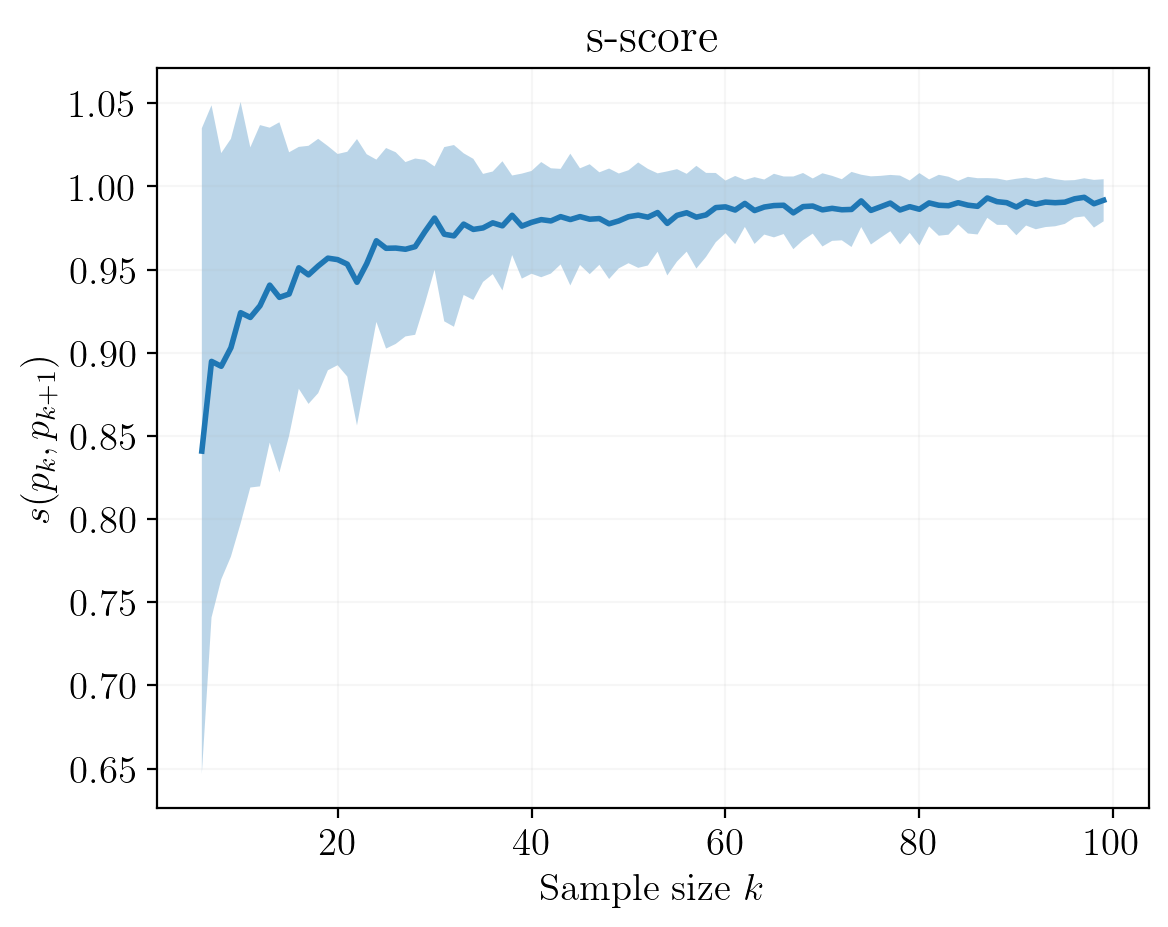

In [53]:
plt.plot(sample_sizes, means)
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3)
plt.title("s-score")
plt.xlabel(r"Sample size $k$")
plt.ylabel(r"$\text{s-score}(p_k, p_{k+1})$")
plt.show()